In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

In [3]:
data = pd.read_csv("../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv")
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


<AxesSubplot:xlabel='DEATH_EVENT', ylabel='count'>

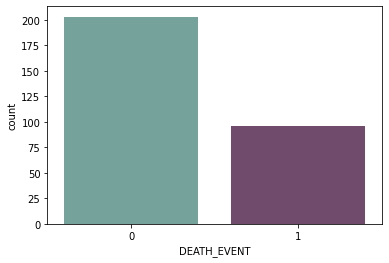

In [5]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
cols= ["#6daa9f","#774571"]
sns.countplot(x= data["DEATH_EVENT"], palette= cols)

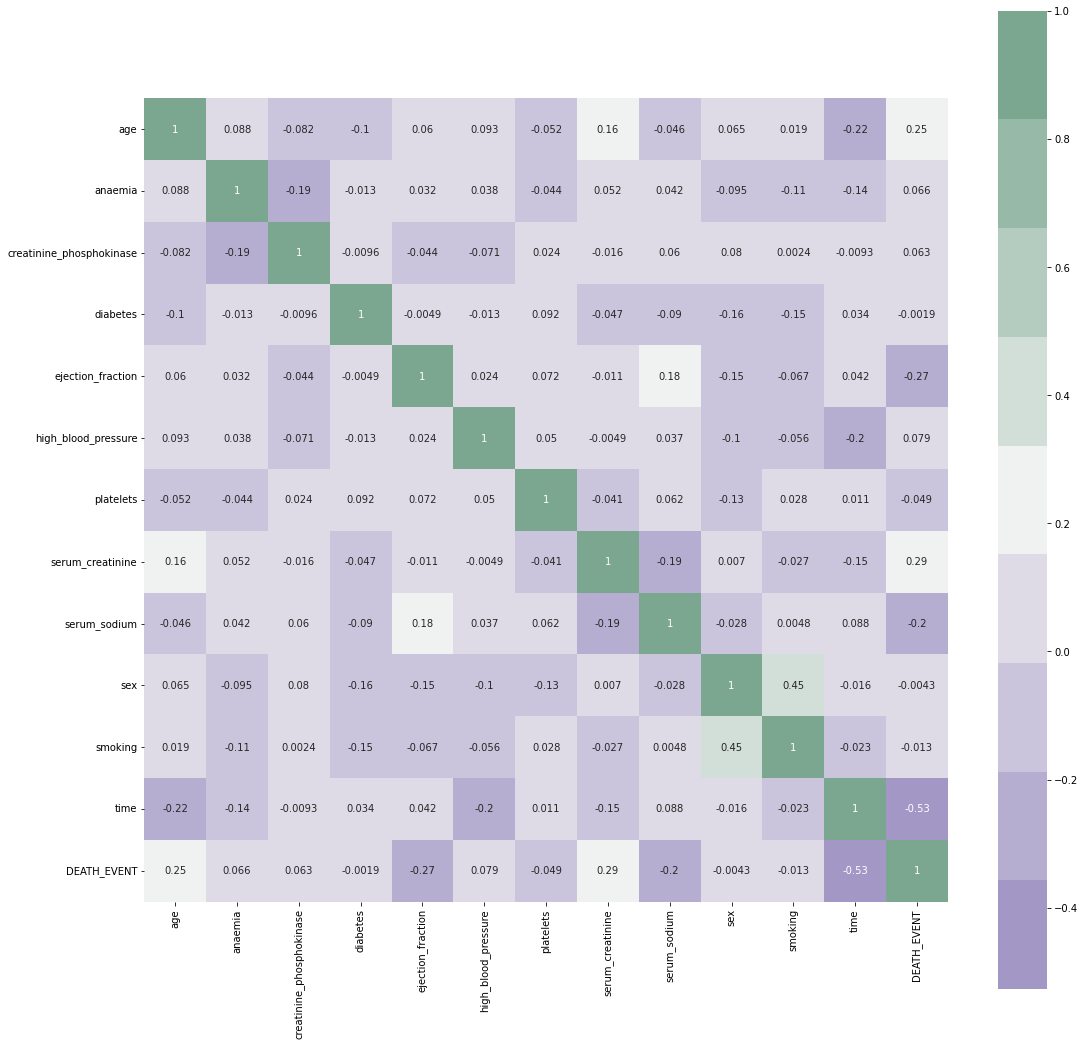

In [6]:
#Examaning a corelation matrix of all the features 
cmap = sns.diverging_palette(275,150,  s=40, l=65, n=9)
corrmat = data.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True);

Text(0.5, 1.0, 'Distribution Of Age')

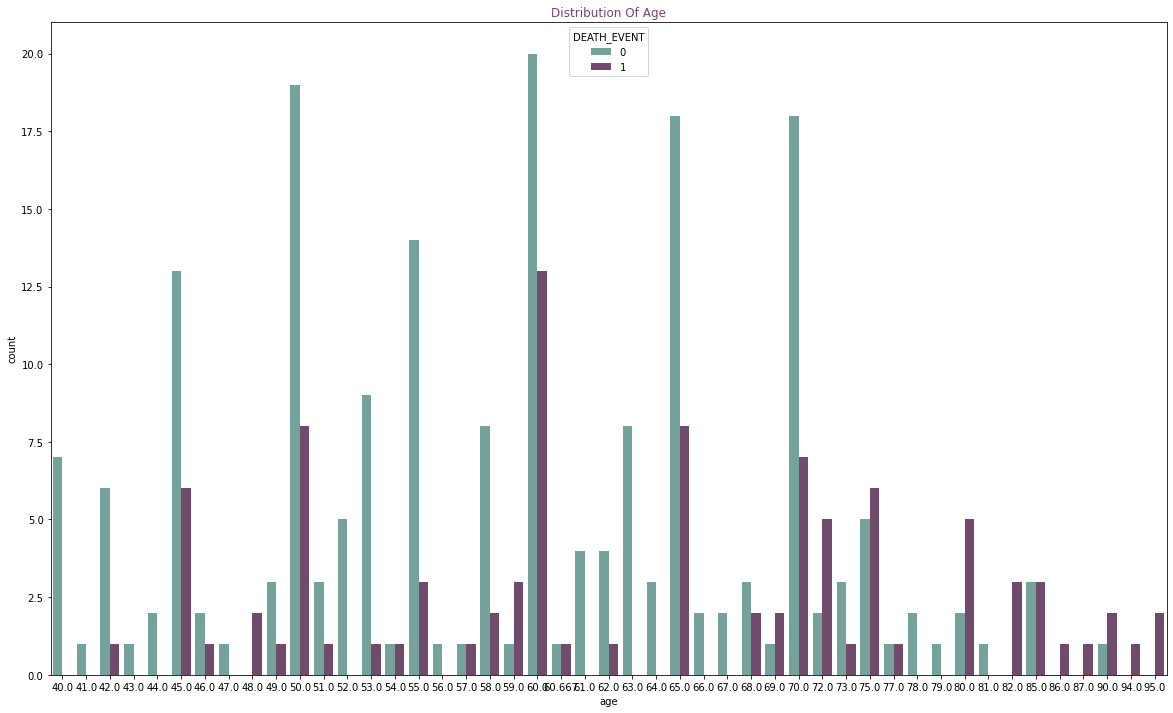

In [7]:
#Evauating age distrivution 
plt.figure(figsize=(20,12))
#colours =["#774571","#b398af","#f1f1f1" ,"#afcdc7", "#6daa9f"]
Days_of_week=sns.countplot(x=data['age'],data=data, hue ="DEATH_EVENT",palette = cols)
Days_of_week.set_title("Distribution Of Age", color="#774571")

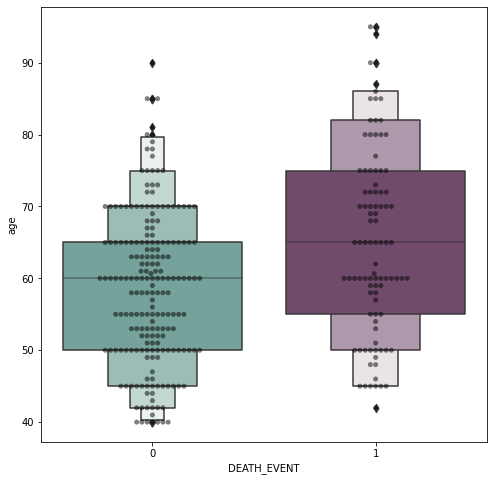

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 17.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


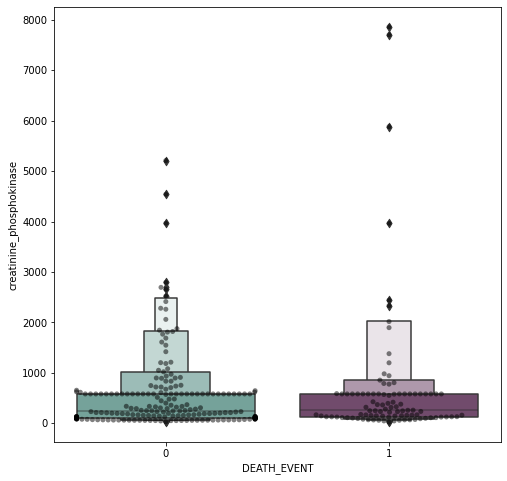

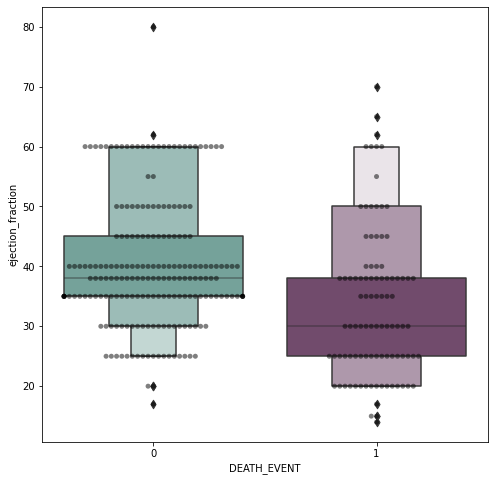

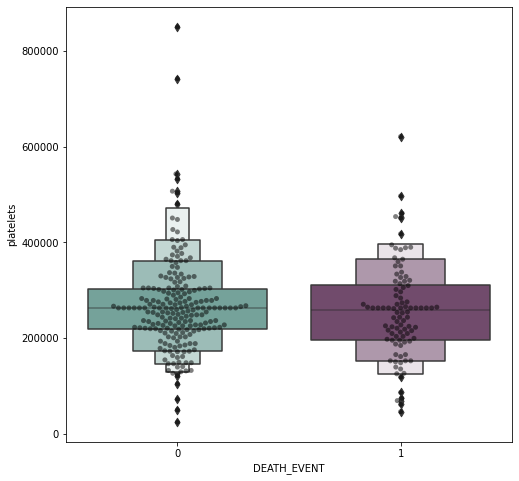

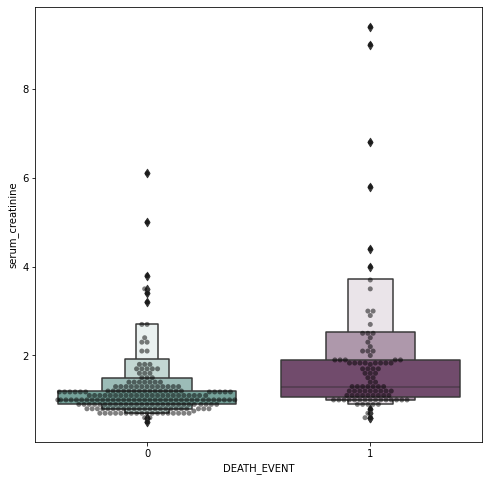

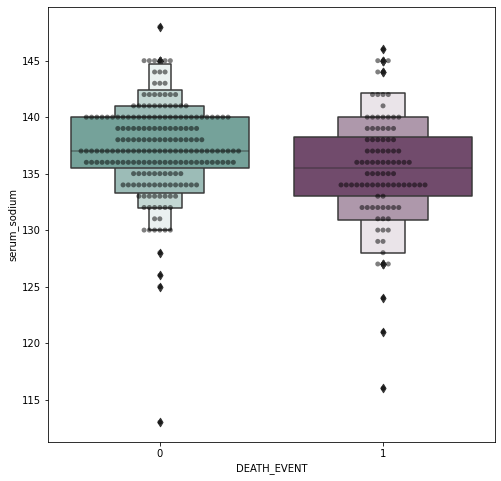

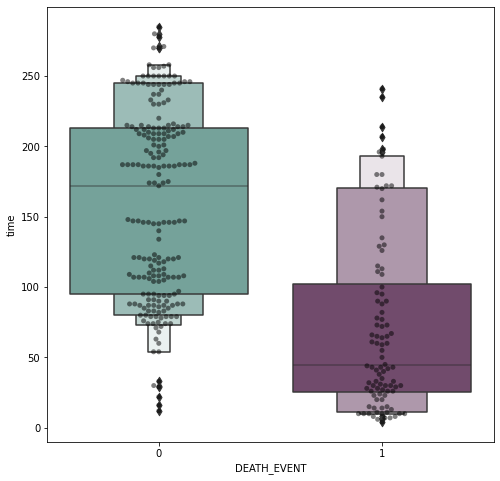

In [8]:
# Boxen and swarm plot of some non binary features.
feature = ["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium", "time"]
for i in feature:
    plt.figure(figsize=(8,8))
    sns.swarmplot(x=data["DEATH_EVENT"], y=data[i], color="black", alpha=0.5)
    sns.boxenplot(x=data["DEATH_EVENT"], y=data[i], palette=cols)
    plt.show()

<AxesSubplot:xlabel='time', ylabel='age'>

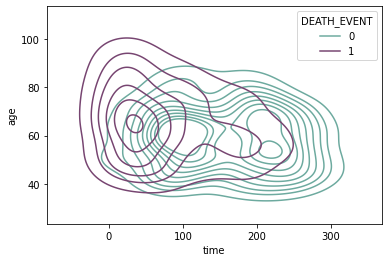

In [9]:
sns.kdeplot(x=data["time"], y=data["age"], hue =data["DEATH_EVENT"], palette=cols)

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


In [11]:
#assigning values to features as X and target as y
X=data.drop(["DEATH_EVENT"],axis=1)
y=data["DEATH_EVENT"]

In [12]:
#Set up a standard scaler for the features
col_names = list(X.columns)
s_scaler = preprocessing.StandardScaler()
X_df= s_scaler.fit_transform(X)
X_df = pd.DataFrame(X_df, columns=col_names)   
X_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,5.703353e-16,1.001676,-1.754448,-0.828124,-0.070223,0.771889,2.877170
anaemia,299.0,1.009969e-16,1.001676,-0.871105,-0.871105,-0.871105,1.147968,1.147968
creatinine_phosphokinase,299.0,0.000000e+00,1.001676,-0.576918,-0.480393,-0.342574,0.000166,7.514640
diabetes,299.0,9.060014e-17,1.001676,-0.847579,-0.847579,-0.847579,1.179830,1.179830
ejection_fraction,299.0,-3.267546e-17,1.001676,-2.038387,-0.684180,-0.007077,0.585389,3.547716
high_blood_pressure,299.0,0.000000e+00,1.001676,-0.735688,-0.735688,-0.735688,1.359272,1.359272
platelets,299.0,7.723291e-17,1.001676,-2.440155,-0.520870,-0.013908,0.411120,6.008180
serum_creatinine,299.0,1.425838e-16,1.001676,-0.865509,-0.478205,-0.284552,0.005926,7.752020
serum_sodium,299.0,-8.673849e-16,1.001676,-5.363206,-0.595996,0.085034,0.766064,2.582144
sex,299.0,-8.911489e-18,1.001676,-1.359272,-1.359272,0.735688,0.735688,0.735688


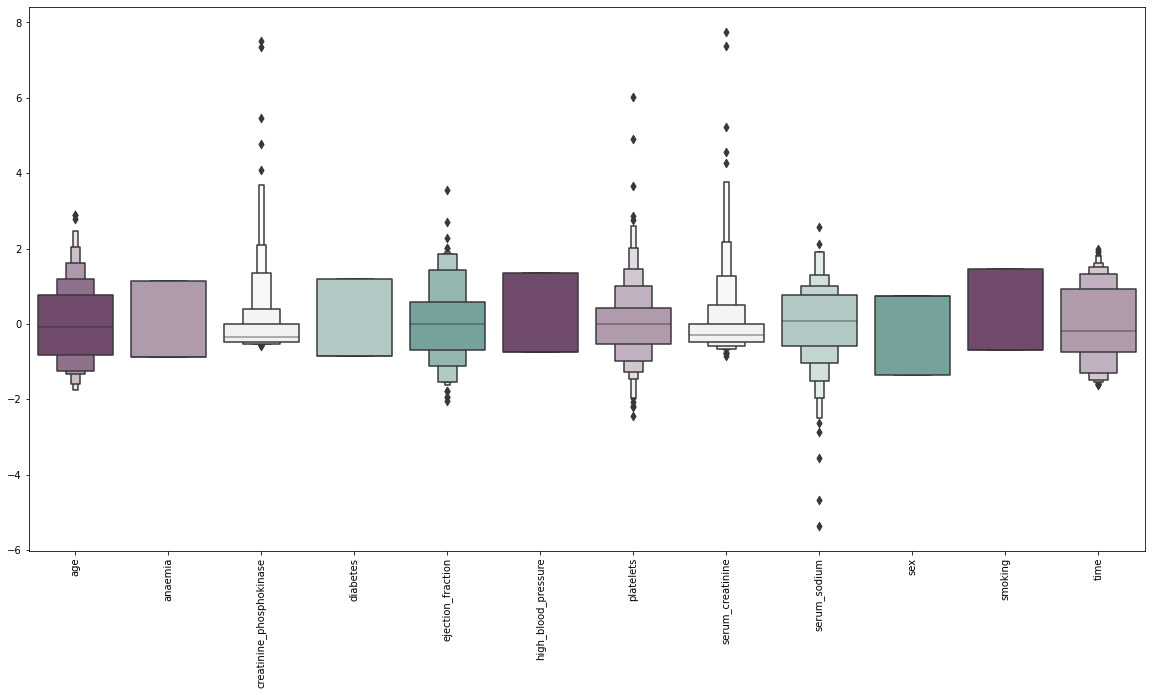

In [13]:
#looking at the scaled features
colours =["#774571","#b398af","#f1f1f1" ,"#afcdc7", "#6daa9f"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = X_df,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [14]:
#spliting test and training sets
X_train, X_test, y_train,y_test = train_test_split(X_df,y,test_size=0.25,random_state=7)

In [15]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True)

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 500,callbacks=[early_stopping], validation_split=0.2)

2022-07-08 05:52:20.086877: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-08 05:52:20.477917: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
6/6 [==============================] - 1s 48ms/step - loss: 0.6929 - accuracy: 0.6369 - val_loss: 0.6922 - val_accuracy: 0.6667
Epoch 2/500
6/6 [==============================] - 0s 9ms/step - loss: 0.6919 - accuracy: 0.6480 - val_loss: 0.6913 - val_accuracy: 0.6667
Epoch 3/500
6/6 [==============================] - 0s 9ms/step - loss: 0.6912 - accuracy: 0.6480 - val_loss: 0.6903 - val_accuracy: 0.6667
Epoch 4/500
6/6 [==============================] - 0s 9ms/step - loss: 0.6903 - accuracy: 0.6480 - val_loss: 0.6892 - val_accuracy: 0.6667
Epoch 5/500
6/6 [==============================] - 0s 9ms/step - loss: 0.6893 - accuracy: 0.6480 - val_loss: 0.6881 - val_accuracy: 0.6667
Epoch 6/500
6/6 [==============================] - 0s 9ms/step - loss: 0.6881 - accuracy: 0.6480 - val_loss: 0.6869 - val_accuracy: 0.6667
Epoch 7/500
6/6 [==============================] - 0s 8ms/step - loss: 0.6868 - accuracy: 0.6480 - val_loss: 0.6855 - val_accuracy: 0.6667
Epoch 8/500
6/6 [=========

In [16]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))



val_accuracy: 71.42%


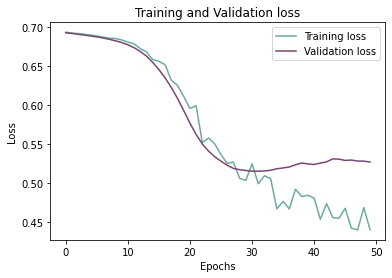

In [17]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#6daa9f", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#774571", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

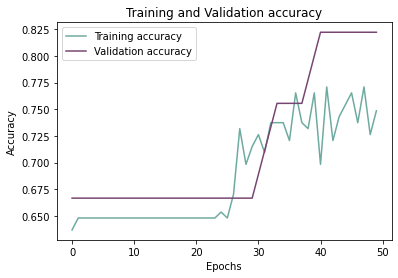

In [18]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#6daa9f", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#774571", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
np.set_printoptions()

<AxesSubplot:>

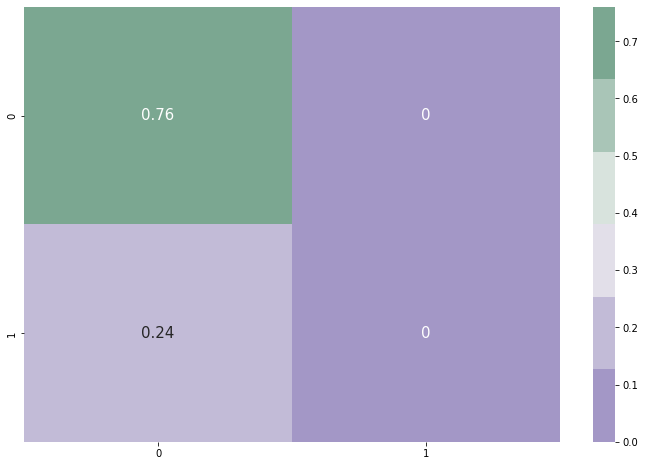

In [20]:
# confusion matrix
cmap1 = sns.diverging_palette(275,150,  s=40, l=65, n=6)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86        57
           1       0.00      0.00      0.00        18

    accuracy                           0.76        75
   macro avg       0.38      0.50      0.43        75
weighted avg       0.58      0.76      0.66        75



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
